## Import necessary libraries for this project

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import glob

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [90]:
TRAIN_DIR = "/kaggle/input/arabic-chars-mnist/train"
TEST_DIR = "/kaggle/input/arabic-chars-mnist/test"

## Loading the Dataset of the images and storing as a list

In [91]:

train_images = [os.path.join(TRAIN_DIR, i) for i in os.listdir(TRAIN_DIR) if i.endswith('.jpg')] 
test_images = [os.path.join(TEST_DIR, i) for i in os.listdir(TEST_DIR) if i.endswith('.jpg')]

## get_labels


    Function that return the labels of the image from image path

In [92]:
def get_labels(fname):
    parts = re.split('/',fname)[-1]
    part=re.split(r'(\d+)',parts)
    return part[0]

In [93]:
path_and_label_train = []
for filename in glob.glob('../input/arabic-chars-mnist/train/*.jpg'):
    path_and_label_train.append([filename, get_labels(filename)])
df_train = pd.DataFrame(path_and_label_train, columns=['path', 'label'])
df_train

,path,label
0,../input/arabic-chars-mnist/train/alef1792.jpg,alef
1,../input/arabic-chars-mnist/train/ain367.jpg,ain
2,../input/arabic-chars-mnist/train/beh9646.jpg,beh
3,../input/arabic-chars-mnist/train/teh3604.jpg,teh
4,../input/arabic-chars-mnist/train/teh10548.jpg,teh
...,...,...
13435,../input/arabic-chars-mnist/train/qaf10469.jpg,qaf
13436,../input/arabic-chars-mnist/train/khah10580.jpg,khah
13437,../input/arabic-chars-mnist/train/hah4078.jpg,hah
13438,../input/arabic-chars-mnist/train/alef5824.jpg,alef


## Data Preprocessing 

Here, we'll prepare the images for the model:

1- Resizing images to ensure uniformity.



2- Normalizing pixel values to aid in training the neural network.


3- Converting labels to a format suitable for training (like one-hot encoding if necessary).

In [94]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Define image dimensions
img_width, img_height = 28, 28

# Function to preprocess images
def preprocess_images(image_paths, img_width, img_height):
    images = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in image_paths]
    images = [cv2.resize(img, (img_width, img_height)) for img in images]
    images = np.array(images) / 255.0  # Normalize to [0, 1]
    return images

# Create a mapping from label names to indices
unique_labels = sorted(df_train['label'].unique())
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}

# Preprocess images
X_train = preprocess_images(df_train['path'].values, img_width, img_height)

# Convert labels to indices and then to one-hot encoding
y_train = to_categorical([label_to_index[label] for label in df_train['label']])

## Split the Data

In [95]:
# Split data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## CNN Model Building

In [96]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
num_classes = 28
model = Sequential([
    # First Convolutional Block
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(img_width, img_height, 1)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),
    
    # Second Convolutional Block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),
    
    # Third Convolutional Block
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.4),
    
    # Classifier Head
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 28)             │        14,364 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,565,980 (5.97 MB)

 Trainable params: 1,565,084 (5.97 MB)

 Non-trainable params: 896 (3.50 KB)

In [97]:
num_classes = y_train.shape[1]  

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 1)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [98]:
X_train = X_train.reshape(-1, img_width, img_height, 1)
X_val = X_val.reshape(-1, img_width, img_height, 1)

In [99]:
print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Validation data shape:", X_val.shape)
print("Validation labels shape:", y_val.shape)

Training data shape: (10752, 28, 28, 1)
Training labels shape: (10752, 28)
Validation data shape: (2688, 28, 28, 1)
Validation labels shape: (2688, 28)


## Model Training

## Model Training with  batch_size=64

In [79]:
from keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train, y_train, 
    epochs=100,  
    validation_data=(X_val, y_val),
    batch_size=64,
    callbacks=[early_stopping]  # Pass the early stopping callback to the fit method
)


Epoch 1/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.1080 - loss: 3.0754 - val_accuracy: 0.4152 - val_loss: 2.0152
Epoch 2/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.3558 - loss: 2.0621 - val_accuracy: 0.6057 - val_loss: 1.2898
Epoch 3/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.4967 - loss: 1.5220 - val_accuracy: 0.6853 - val_loss: 1.0138
Epoch 4/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.5678 - loss: 1.2708 - val_accuracy: 0.7385 - val_loss: 0.8419
Epoch 5/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.6254 - loss: 1.0869 - val_accuracy: 0.7734 - val_loss: 0.7189
Epoch 6/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.6699 - loss: 0.9684 - val_accuracy: 0.7913 - val_loss: 0.6529
Epoch 7/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.6963 - loss: 0.8804 - val_accuracy: 0.8188 - val_loss: 0.6035
Epoch 8/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.7247 - loss: 0.8015 

## Model Training with  batch_size=32

In [100]:
from keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train, y_train, 
    epochs=100,  
    validation_data=(X_val, y_val),
    batch_size=32,
    callbacks=[early_stopping]  # Pass the early stopping callback to the fit method
)


Epoch 1/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.1496 - loss: 2.9183 - val_accuracy: 0.5398 - val_loss: 1.5349
Epoch 2/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.4648 - loss: 1.6380 - val_accuracy: 0.7091 - val_loss: 0.9915
Epoch 3/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.5955 - loss: 1.2128 - val_accuracy: 0.7757 - val_loss: 0.7263
Epoch 4/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.6729 - loss: 0.9697 - val_accuracy: 0.8054 - val_loss: 0.6074
Epoch 5/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.7176 - loss: 0.8194 - val_accuracy: 0.8203 - val_loss: 0.5247
Epoch 6/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.7480 - loss: 0.7212 - val_accuracy: 0.8404 - val_loss: 0.4799
Epoch 7/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.7842 - loss: 0.6244 - val_accuracy: 0.8594 - val_loss: 0.4417
Epoch 8/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.8056 - loss: 0.5603 

## Model Evaluation

In [101]:
def get_labels(filename):
    parts = re.split('/', filename)[-1]
    part = re.split(r'(\d+)', parts)
    return part[0]  

# Create a list of labels for test images
test_labels = [get_labels(path) for path in test_images]

# Create y_test using label_to_index map and then convert to one-hot encoding
y_test = to_categorical([label_to_index[label] for label in test_labels], num_classes=num_classes)

In [103]:
X_test = preprocess_images(test_images, img_width, img_height)
X_test = X_test.reshape(-1, img_width, img_height, 1)  # Reshape 

## The result with batch_size=64

In [82]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9081 - loss: 0.3083
Test accuracy: 0.9050595164299011


## The result with batch_size=32

In [104]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9158 - loss: 0.2958
Test accuracy: 0.9184523820877075


In [83]:
print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

Test data shape: (3360, 28, 28, 1)
Test labels shape: (3360, 28)


## Plotting accuracy of the model

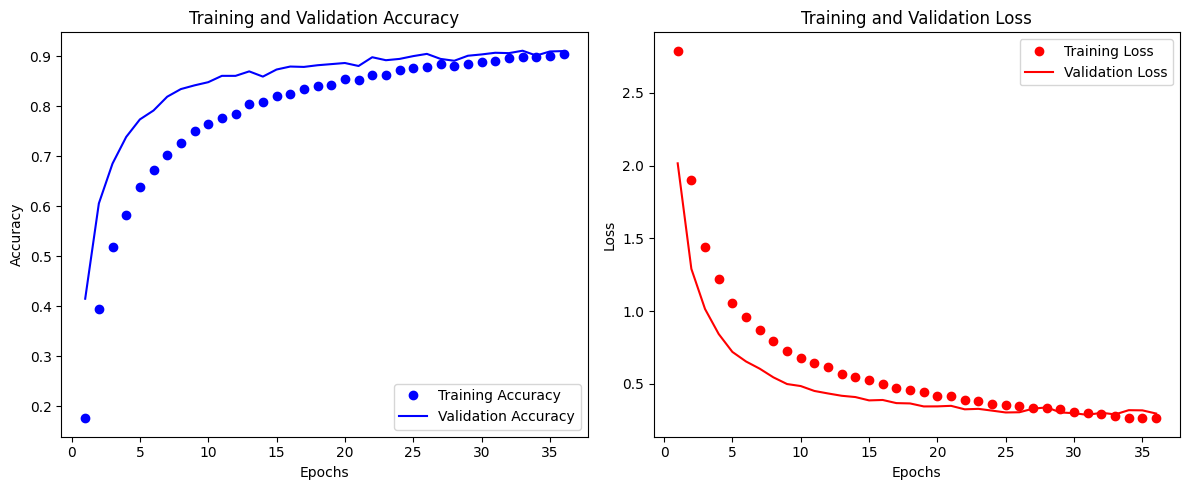

In [84]:
import matplotlib.pyplot as plt

# Extracting the history of training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Extracting the history of training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

# Getting the number of epochs
epochs = range(1, len(acc) + 1)

# Plotting training and validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'ro', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Model predictions and decoding

In [105]:
# Making predictions on the test set
predictions = model.predict(X_test)

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [106]:
# Convert probabilities to class indices
predicted_classes = np.argmax(predictions, axis=1)

# Mapping indices back to original labels
index_to_label = {v: k for k, v in label_to_index.items()}  # Reverse the label_to_index dictionary
predicted_labels = [index_to_label[idx] for idx in predicted_classes]

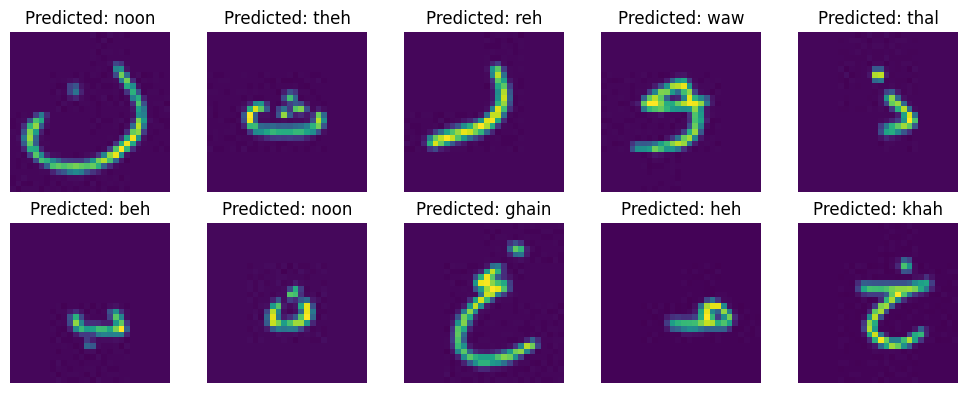

In [108]:
import random

# Function to randomly select images and their labels
def select_random_images(images, labels, num_images):
    random_indices = random.sample(range(len(images)), num_images)
    random_images = [images[i] for i in random_indices]
    random_labels = [labels[i] for i in random_indices]
    return random_images, random_labels

# Number of random images to select
num_random_images = 20

# Select random images and their labels
random_images, random_labels = select_random_images(X_test, predicted_labels, num_random_images)

# Plot the randomly selected images with their predicted labels
plot_images(random_images, random_labels, 2, 5)
